Import All Libraries Needed

In [126]:
pip install py-midi

In [127]:
pip install h5py pyyaml 

In [128]:
import numpy as np
import pandas as pd
import tensorflow as tf 
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import seaborn as sns
from tqdm import tqdm
import glob
import midi
from tensorflow.python.ops import control_flow_ops
import msgpack
import sys
import io
import os, os.path
import glob
import pickle

from music21 import converter, corpus, instrument, midi, note, chord, pitch, stream

from tensorflow.contrib.rnn import *
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import CuDNNLSTM
from keras.layers import Activation
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint
from tensorflow import keras
%matplotlib inline
print("Libraries Loaded")


Libraries Loaded


Load Midifiles

In [129]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
os.chdir("/content/drive/My Drive/The New Order Deal/Computer Science/2019 Machine Learning/Notes")
path, dirs, files = next(os.walk("Pop_Music_Midi"))

for root, dirs, files in os.walk("Pop_Music_Midi", topdown=False):
   for name in files:
        print (name)


Mounted at /content/drive
Girl On Fire - Verse.midi
Rolling In The Deep - Chorus.midi
Blank Space - Chorus.midi
Rock That Body - Chorus.midi
Shake It Off - Pre Chorus.midi
Ex's And Oh's - Chorus.midi
Locked Out Of Heaven - Chorus.midi
Barbie Girl - Chorus.midi
Hot N Cold - Bridge.midi
All The Small Things - Chorus.midi
When I Was Your Man - Pre Chorus.midi
Blank Space - Pre Chorus.midi
How Deep Is Your Love - Chorus.midi
Mr Saxobeat - Verse.midi
Fix You - Verse.midi
Barbie Girl - Verse.midi
California Gurls - Chorus.midi
You Belong With Me - Verse.midi
Outside feat Ellie Goulding - Chorus.midi
All The Small Things - Verse.midi
Tiny Dancer - Pre Chorus.midi
Love Story - Verse.midi
Say My Name - Verse.midi
Dark Horse - Chorus.midi
Love Me Harder ft The Weeknd - Verse.midi
I Miss You - Chorus.midi
Say My Name - Pre Chorus.midi
Roar - Verse.midi
White Flag - Verse.midi
When I Was Your Man - Verse.midi
You Belong With Me - Pre Chorus.midi
Toxic - Verse.midi
Love Story - Chorus.midi
Hot N Co

LSTM Code

In [0]:
def open_midi(midi_path, remove_drums):
    # There is an one-line method to read MIDIs
    # but to remove the drums we need to manipulate some
    # low level MIDI events.;
    mf = midi.MidiFile()
    mf.open(midi_path)
    mf.read()
    mf.close()
    if (remove_drums):
        for i in range(len(mf.tracks)):
            mf.tracks[i].events = [ev for ev in mf.tracks[i].events if ev.channel != 10]          

    return midi.translate.midiFileToStream(mf)

In [143]:
base_midi = open_midi("Baby I'm Yours - Chorus.midi",True)
base_midi

<music21.stream.Score 0x7f49a0e84ba8>

In [131]:
def list_instruments(midi):
    partStream = midi.parts.stream()
    print("List of instruments found on MIDI file:")
    for p in partStream:
        aux = p
        print (p.partName)

list_instruments(base_midi)

List of instruments found on MIDI file:
None
None
None


In [0]:
def extract_notes(midi_part):
    parent_element = []
    ret = []
    for nt in midi_part.flat.notes:        
        if isinstance(nt, note.Note):
            ret.append(max(0.0, nt.pitch.ps))
            parent_element.append(nt)
        elif isinstance(nt, chord.Chord):
            for pitch in nt.pitches:
                ret.append(max(0.0, pitch.ps))
                parent_element.append(nt)
    
    return ret, parent_element

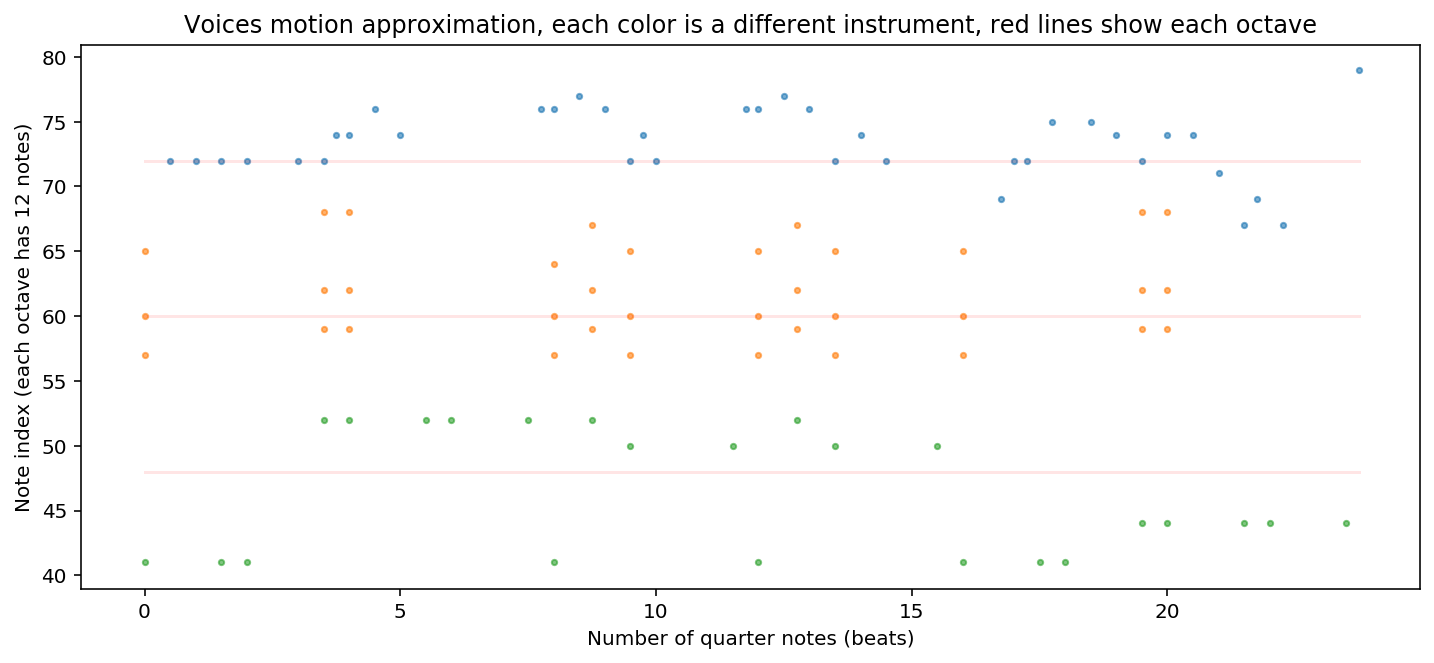

In [133]:
def print_parts_countour(midi):
    fig = plt.figure(figsize=(12, 5))
    ax = fig.add_subplot(1, 1, 1)
    minPitch = pitch.Pitch('C10').ps
    maxPitch = 0
    xMax = 0
    for i in range(len(midi.parts)):
        top = midi.parts[i].flat.notes                  
        y, parent_element = extract_notes(top)
        if (len(y) < 1): continue
            
        x = [n.offset for n in parent_element]
        ax.scatter(x, y, alpha=0.6, s=7)
        
        aux = min(y)
        if (aux < minPitch): minPitch = aux
            
        aux = max(y)
        if (aux > maxPitch): maxPitch = aux
            
        aux = max(x)
        if (aux > xMax): xMax = aux
    
    for i in range(1, 10):
        linePitch = pitch.Pitch('C{0}'.format(i)).ps
        if (linePitch > minPitch and linePitch < maxPitch):
            ax.add_line(mlines.Line2D([0, xMax], [linePitch, linePitch], color='red', alpha=0.1))            

    plt.ylabel("Note index (each octave has 12 notes)")
    plt.xlabel("Number of quarter notes (beats)")
    plt.title('Voices motion approximation, each color is a different instrument, red lines show each octave')
    plt.show()

# Focusing only on 6 first measures to make it easier to understand.
print_parts_countour(base_midi.measures(0, 6))

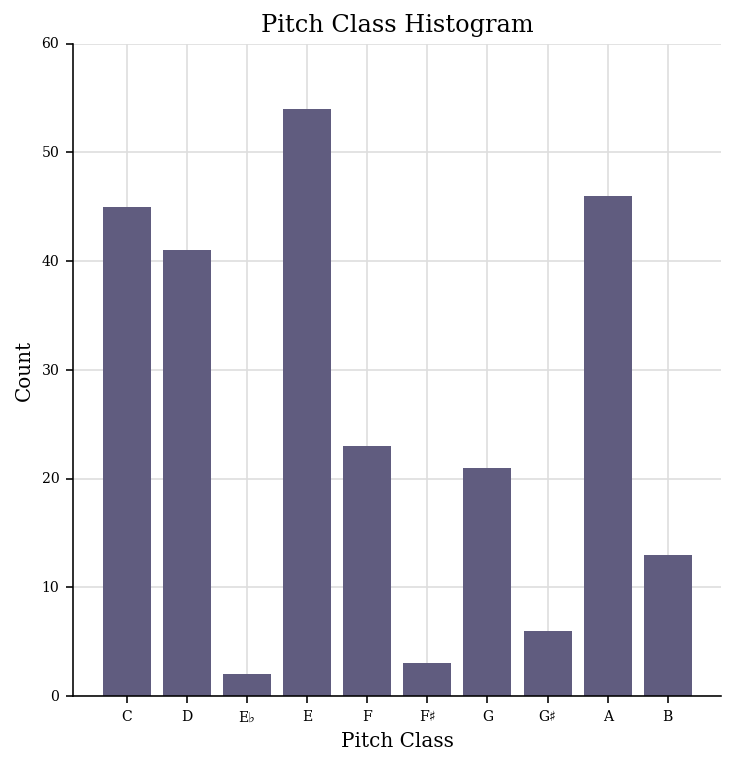

In [86]:
base_midi.plot('histogram', 'pitchClass', 'count')

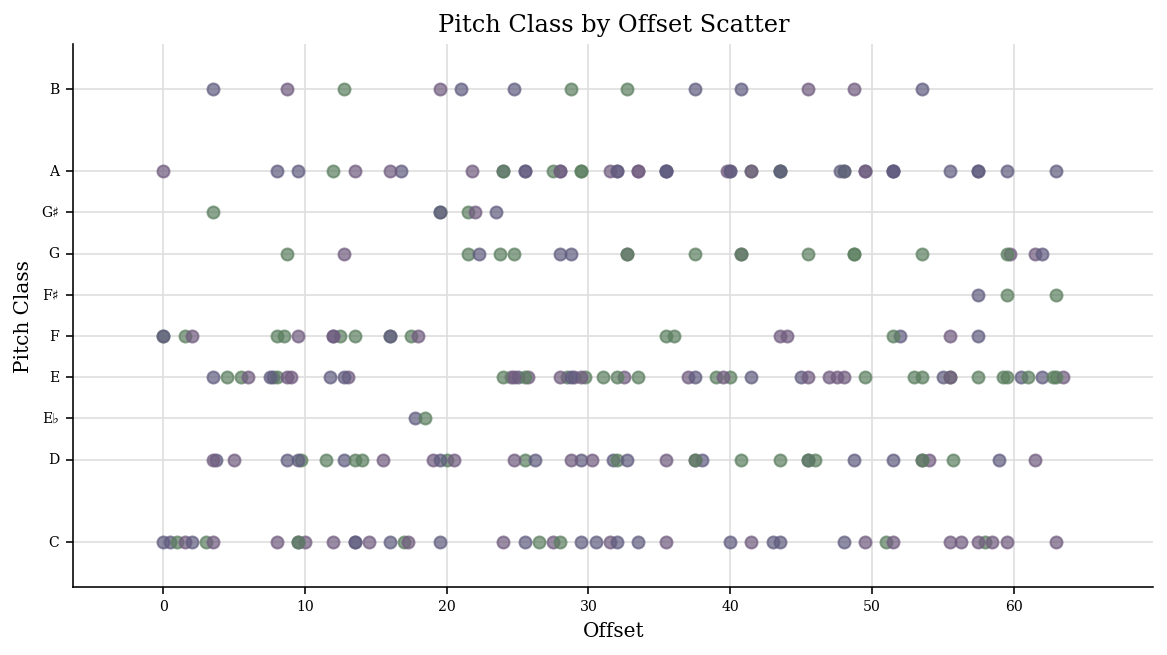

In [87]:
base_midi.plot('scatter', 'offset', 'pitchClass')

In [149]:
timeSignature = base_midi.getTimeSignatures()[0]
music_analysis = base_midi.analyze('key')
print("Music time signature: {0}/{1}".format(timeSignature.beatCount, timeSignature.denominator))
print("Expected music key: {0}".format(music_analysis))
print("Music key confidence: {0}".format(music_analysis.correlationCoefficient))
print("Other music key alternatives:")
for analysis in music_analysis.alternateInterpretations:
    if (analysis.correlationCoefficient > 0.5):
        print(analysis)

Music time signature: 4/4
Expected music key: a minor
Music key confidence: 0.9153071273394088
Other music key alternatives:
d minor
C major
F major
G major


In [0]:
def get_notes():
  notes = []
  #going through each song file in the music folder
  for file in glob.glob("Pop_Music_Midi/*.midi"):
        midi = converter.parse(file)

        print("Parsing %s" % file)

        notes_to_parse = None

        try: # file has instrument parts
            s2 = instrument.partitionByInstrument(midi)
            notes_to_parse = s2.parts[0].recurse() 
        except: # file has notes in a flat structure
            notes_to_parse = midi.flat.notes
        #differentiating between simple notes and chords
        for element in notes_to_parse:
            if isinstance(element, note.Note):
                notes.append(str(element.pitch))
            elif isinstance(element, chord.Chord):
                notes.append('.'.join(str(n) for n in element.normalOrder))
  return notes
get_notes()

In [0]:
def prepare_sequences(notes, n_vocab):
    """ Prepare the sequences used by the Neural Network """
    sequence_length = 100

    # get all pitch names
    pitchnames = sorted(set(item for item in notes))

     # create a dictionary to map pitches to integers
    note_to_int = dict((note, number) for number, note in enumerate(pitchnames))

    network_input = []
    network_output = []

    # create input sequences and the corresponding outputs
    for i in range(0, len(notes) - sequence_length, 1):
        sequence_in = notes[i:i + sequence_length]
        sequence_out = notes[i + sequence_length]
        network_input.append([note_to_int[char] for char in sequence_in])
        network_output.append(note_to_int[sequence_out])

    n_patterns = len(network_input)

    # reshape the input into a format compatible with CuDNNLSTM layers
    network_input = np.reshape(network_input, (n_patterns, sequence_length, 1))
    # normalize input
    network_input = network_input / float(n_vocab)

    network_output = np_utils.to_categorical(network_output)

    return (network_input, network_output)

In [0]:
def create_network(network_input, n_vocab):
    """ create the structure of the neural network """
    model = Sequential()
    model.add(CuDNNLSTM(512,input_shape=(network_input.shape[1], network_input.shape[2]),return_sequences=True))
    model.add(Dropout(0.3))
    model.add(CuDNNLSTM(512, return_sequences=True))
    model.add(Dropout(0.3))
    model.add(CuDNNLSTM(512))
    model.add(Dense(256))
    model.add(Dropout(0.3))
    model.add(Dense(n_vocab))
    model.add(Activation('softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='rmsprop')
    #model.load_weights('new_weights.hdf5')
    return model

In [153]:
notes = get_notes()
# get amount of pitch names
n_vocab = len(set(notes))
network_input, network_output = prepare_sequences(notes, n_vocab)
print(network_input.shape)
print(network_output.shape)
model = create_network(network_input, n_vocab)
checkpoint = ModelCheckpoint('model-{epoch:03d}-{loss:03f}.hdf5',save_best_only=True, mode='auto')  
model.fit(network_input, network_output, epochs=30, batch_size=64, callbacks=[checkpoint])
model.save('better_model.hdf5')

Parsing Pop_Music_Midi/Girl On Fire - Verse.midi
Parsing Pop_Music_Midi/Rolling In The Deep - Chorus.midi
Parsing Pop_Music_Midi/Blank Space - Chorus.midi
Parsing Pop_Music_Midi/Rock That Body - Chorus.midi
Parsing Pop_Music_Midi/Shake It Off - Pre Chorus.midi
Parsing Pop_Music_Midi/Ex's And Oh's - Chorus.midi
Parsing Pop_Music_Midi/Locked Out Of Heaven - Chorus.midi
Parsing Pop_Music_Midi/Barbie Girl - Chorus.midi
Parsing Pop_Music_Midi/Hot N Cold - Bridge.midi
Parsing Pop_Music_Midi/All The Small Things - Chorus.midi
Parsing Pop_Music_Midi/When I Was Your Man - Pre Chorus.midi
Parsing Pop_Music_Midi/Blank Space - Pre Chorus.midi
Parsing Pop_Music_Midi/How Deep Is Your Love - Chorus.midi
Parsing Pop_Music_Midi/Mr Saxobeat - Verse.midi
Parsing Pop_Music_Midi/Fix You - Verse.midi
Parsing Pop_Music_Midi/Barbie Girl - Verse.midi
Parsing Pop_Music_Midi/California Gurls - Chorus.midi
Parsing Pop_Music_Midi/You Belong With Me - Verse.midi
Parsing Pop_Music_Midi/Outside feat Ellie Goulding - 

/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:707: RuntimeWarning: Can save best model only with val_loss available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


13724/13724 [==============================] - 15s 1ms/step - loss: 3.4034
Epoch 3/30
13724/13724 [==============================] - 15s 1ms/step - loss: 3.3924
Epoch 4/30
13724/13724 [==============================] - 15s 1ms/step - loss: 3.3869
Epoch 5/30
13724/13724 [==============================] - 15s 1ms/step - loss: 3.3853
Epoch 6/30
13724/13724 [==============================] - 15s 1ms/step - loss: 3.3847
Epoch 7/30
13724/13724 [==============================] - 15s 1ms/step - loss: 3.3831
Epoch 8/30
13724/13724 [==============================] - 15s 1ms/step - loss: 3.3842
Epoch 9/30
13724/13724 [==============================] - 15s 1ms/step - loss: 3.3841
Epoch 10/30
13724/13724 [==============================] - 15s 1ms/step - loss: 3.3832
Epoch 11/30
13724/13724 [==============================] - 15s 1ms/step - loss: 3.3828
Epoch 12/30
13724/13724 [==============================] - 15s 1ms/step - loss: 3.3844
Epoch 13/30
13724/13724 [==============================] - 15s

In [0]:
def generate_notes(model, network_input, pitchnames, n_vocab):
    """ Generate notes from the neural network based on a sequence of notes """
    # pick a random sequence from the input as a starting point for the prediction
    start = np.random.randint(0, len(network_input)-1)

    int_to_note = dict((number, note) for number, note in enumerate(pitchnames))

    pattern = network_input[start]
    prediction_output = []

    # generate 500 notes
    for note_index in range(500):
        prediction_input = np.reshape(pattern, (1, len(pattern), 1))
        prediction_input = prediction_input / float(n_vocab)

        prediction = model.predict(prediction_input, verbose=0)

        index = np.argmax(prediction)
        result = int_to_note[index]
        prediction_output.append(result)

        pattern.append(index)
        pattern = pattern[1:len(pattern)]

    return prediction_output

In [0]:
def create_midi(prediction_output):
    """ convert the output from the prediction to notes and create a midi file
        from the notes """
    offset = 0
    output_notes = []

    # create note and chord objects based on the values generated by the model
    for pattern in prediction_output:
        # pattern is a chord
        if ('.' in pattern) or pattern.isdigit():
            notes_in_chord = pattern.split('.')
            notes = []
            for current_note in notes_in_chord:
                new_note = note.Note(int(current_note))
                new_note.storedInstrument = instrument.Piano()
                notes.append(new_note)
            new_chord = chord.Chord(notes)
            new_chord.offset = offset
            output_notes.append(new_chord)
        # pattern is a note
        else:
            new_note = note.Note(pattern)
            new_note.offset = offset
            new_note.storedInstrument = instrument.Piano()
            output_notes.append(new_note)

        # increase offset each iteration so that notes do not stack
        offset += 0.5

    midi_stream = stream.Stream(output_notes)

    midi_stream.write('midi', fp='test_output2.mid')

In [0]:
def prepare_sequences(notes, pitchnames, n_vocab):
    """ Prepare the sequences used by the Neural Network """
    # map between notes and integers and back
    note_to_int = dict((note, number) for number, note in enumerate(pitchnames))

    sequence_length = 100
    network_input = []
    output = []
    for i in range(0, len(notes) - sequence_length, 1):
        sequence_in = notes[i:i + sequence_length]
        sequence_out = notes[i + sequence_length]
        network_input.append([note_to_int[char] for char in sequence_in])
        output.append(note_to_int[sequence_out])

    n_patterns = len(network_input)

    # reshape the input into a format compatible with CuDNNLSTM layers
    normalized_input = np.reshape(network_input, (n_patterns, sequence_length, 1))
    # normalize input
    normalized_input = normalized_input / float(n_vocab)

    return (network_input, normalized_input)

# Get all pitch names
pitchnames = sorted(set(item for item in notes))
# Get all pitch names
n_vocab = len(set(notes))
network_input, normalized_input = prepare_sequences(notes, pitchnames, n_vocab)
model = keras.models.load_model('better_model.hdf5')
prediction_output = generate_notes(model, network_input, pitchnames, n_vocab)
create_midi(prediction_output)